In [1]:
import sympy as sp
from sympy import cos as c, sin as s, pi, Function as f, Matrix as M
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the independent variable
x, y, t, l1, l2, m1, m2 = sp.symbols("x y t l1 l2 m1 m2")
L1, L2, g = sp.symbols("L1 L2 g")
q1, q2 = f("q1")(t), f("q2")(t)
c1, s1, c2, s2, c12, s12 = c(q1), s(q1), c(q2), s(q2), c(q1 + q2), s(q1 + q2)
t_diff = lambda expr: sp.diff(expr, t) if t in expr.free_symbols else expr

# Define the forward kinematics
R1 = M([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])
T1 = M([[1, 0, l1], [0, 1, 0], [0, 0, 1]])
R2 = M([[c2, -s2, 0], [s2, c2, 0], [0, 0, 1]])
T2 = M([[1, 0, l2], [0, 1, 0], [0, 0, 1]])
Q01 = R1 * T1
Q12 = R2 * T2
Q02 = Q01 * Q12
Q02 = Q02.applyfunc(sp.simplify)
Ph = M([[x], [0], [1]])

dq1 = q1.diff(t)
dq2 = q2.diff(t)
ddq1 = dq1.diff(t)
ddq2 = dq2.diff(t)
tau1, tau2 = sp.symbols("tau1 tau2")

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} = \tau_i$$
$$M(q)\ddot{q} + C(q,\dot{q}) + G(q) = \tau$$


In [2]:
m_t = M(
    [
        [
            m1 * L1**2 + m2 * (L1**2 + 2 * L1 * L2 * c2 + L2**2),
            m2 * (L1 * L2 * c2 + L2**2),
        ],
        [m2 * (L1 * L2 * c2 + L2**2), m2 * L2**2],
    ]
)
c_t_dt = M(
    [[-m2 * L1 * L2 * s2 * (2 * dq1 * dq2 + dq2**2)], [m2 * L1 * L2 * s2 * dq1**2]]
)
g_t = M(
    [
        [(m1 + m2) * g * L1 * c(q1) + m2 * g * L2 * c(q1 + q2)],
        [m2 * g * L2 * c(q1 + q2)],
    ]
)


In [3]:
p1 = M([[L1*c1],[L1*s1]],dtype=float)
p1_d = p1.applyfunc(t_diff)
v1_q = p1_d.T*p1_d
T1 = sp.simplify((m1*v1_q/2)[0])
T1

L1**2*m1*Derivative(q1(t), t)**2/2

In [4]:
p2 = M([[L1*c1+L2*c12],[L1*s1+L2*s12]],dtype=float)
p2_d = p2.applyfunc(t_diff)
v2_q = p2_d.T*p2_d
T2 = sp.simplify((m2*v2_q/2)[0])
T2

m2*(L1**2*Derivative(q1(t), t)**2 + 2*L1*L2*cos(q2(t))*Derivative(q1(t), t)**2 + 2*L1*L2*cos(q2(t))*Derivative(q1(t), t)*Derivative(q2(t), t) + L2**2*Derivative(q1(t), t)**2 + 2*L2**2*Derivative(q1(t), t)*Derivative(q2(t), t) + L2**2*Derivative(q2(t), t)**2)/2

In [5]:
T = T1+T2
T

L1**2*m1*Derivative(q1(t), t)**2/2 + m2*(L1**2*Derivative(q1(t), t)**2 + 2*L1*L2*cos(q2(t))*Derivative(q1(t), t)**2 + 2*L1*L2*cos(q2(t))*Derivative(q1(t), t)*Derivative(q2(t), t) + L2**2*Derivative(q1(t), t)**2 + 2*L2**2*Derivative(q1(t), t)*Derivative(q2(t), t) + L2**2*Derivative(q2(t), t)**2)/2

In [6]:
U1 = sp.simplify((m1*g*p1)[1])
U2 = sp.simplify((m2*g*p2)[1])
U = U1+U2
U

L1*g*m1*sin(q1(t)) + g*m2*(L1*sin(q1(t)) + L2*sin(q1(t) + q2(t)))

In [7]:
L=T-U
dLdq1 = sp.diff(L,q1)
dLdq2 = sp.diff(L,q2)
dLdq1dt = sp.diff(sp.diff(L,dq1),t)
dLdq2dt = sp.diff(sp.diff(L,dq2),t)
e1 = sp.collect(sp.expand(sp.simplify(dLdq1dt-dLdq1)),[ddq1,ddq2])
e2 = sp.collect(sp.expand(sp.simplify(dLdq2dt-dLdq2)),[ddq1,ddq2])

In [47]:
m_t

Matrix([
[L1**2*m1 + m2*(L1**2 + 2*L1*L2*cos(q2(t)) + L2**2), m2*(L1*L2*cos(q2(t)) + L2**2)],
[                     m2*(L1*L2*cos(q2(t)) + L2**2),                      L2**2*m2]])

In [46]:
c_t_dt

Matrix([
[-L1*L2*m2*(2*Derivative(q1(t), t)*Derivative(q2(t), t) + Derivative(q2(t), t)**2)*sin(q2(t))],
[                                                 L1*L2*m2*sin(q2(t))*Derivative(q1(t), t)**2]])

In [12]:
g_t

Matrix([
[L1*g*(m1 + m2)*cos(q1(t)) + L2*g*m2*cos(q1(t) + q2(t))],
[                            L2*g*m2*cos(q1(t) + q2(t))]])

In [13]:
eq = m_t.inv() * (M([[tau1], [tau2]])-c_t_dt - g_t)
eq = eq.applyfunc(sp.trigsimp)
eq

Matrix([
[                                                                   (L1*L2*m2*(2*Derivative(q1(t), t)*Derivative(q2(t), t) + Derivative(q2(t), t)**2)*sin(q2(t)) - L1*g*(m1 + m2)*cos(q1(t)) - L2*g*m2*cos(q1(t) + q2(t)) + tau1)/(L1**2*(m1 + m2*sin(q2(t))**2)) - (L1*cos(q2(t)) + L2)*(-L1*L2*m2*sin(q2(t))*Derivative(q1(t), t)**2 - L2*g*m2*cos(q1(t) + q2(t)) + tau2)/(L1**2*L2*(m1 + m2*sin(q2(t))**2))],
[-(L1*cos(q2(t)) + L2)*(L1*L2*m2*(2*Derivative(q1(t), t)*Derivative(q2(t), t) + Derivative(q2(t), t)**2)*sin(q2(t)) - L1*g*(m1 + m2)*cos(q1(t)) - L2*g*m2*cos(q1(t) + q2(t)) + tau1)/(L1**2*L2*(m1 + m2*sin(q2(t))**2)) + (-L1*L2*m2*sin(q2(t))*Derivative(q1(t), t)**2 - L2*g*m2*cos(q1(t) + q2(t)) + tau2)*(L1**2*m1 + L1**2*m2 + 2*L1*L2*m2*cos(q2(t)) + L2**2*m2)/(L1**2*L2**2*m2*(m1 + m2*sin(q2(t))**2))]])

In [14]:
# sols = sp.solve(eq, [ddq1, ddq2], rational=True, simplify=True)
# ddq1_sol = sols[ddq1]
# ddq2_sol = sols[ddq2]
sols = eq
ddq1_sol = sols[0]
ddq2_sol = sols[1]

> convert to state npace form:

Assume $x=\begin{bmatrix} q & \dot{q} \end{bmatrix}^T$, then we have:

$$
\begin{bmatrix}x_1 \\ x_2 \\ x_3 \\ x_4\end{bmatrix} = \begin{bmatrix} q_1 \\ \dot{q}_1 \\ q_2 \\\dot{q}_2 \end{bmatrix}
\Longrightarrow
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4\end{bmatrix} = \begin{bmatrix} x_2 \\  \ddot{q}_1 \\ x_4 \\ \ddot{q}_2 \end{bmatrix}
$$

In other words, we have:
$$\dot{x} = \begin{bmatrix} \dot{q} \\ M(q)^{-1}(\tau - C(q,\dot{q}) - G(q)) \end{bmatrix}$$


In [15]:
x1, x2, x3, x4 = sp.symbols("x1 x2 x3 x4", cls=sp.Function)
x1, x2, x3, x4 = x1(t), x2(t), x3(t), x4(t)
# x1_d, x2_d, x3_d, x4_d = sp.symbols(r'\dot{x}_1 \dot{x}_2 \dot{x}_3 \dot{x}_4')
# x = M([x1, x2, x3, x4])
# x_d = M([x1_d, x2_d, x3_d, x4_d])
# substitute the symbols with the states
x1_d = x3
x2_d = x4
x3_d = ddq1_sol.subs({q1: x1, q2: x2, dq1: x3, dq2: x4})
x4_d = ddq2_sol.subs({q1: x1, q2: x2, dq1: x3, dq2: x4})
Gx = g_t.subs({q1: x1, q2: x2})
Cx = c_t_dt.subs({q1: x1, q2: x2, dq1: x3, dq2: x4})
# define functions for the dynamics
x1_d_f = sp.lambdify(x1.diff(t), x1.diff(t))
x2_d_f = sp.lambdify(x2.diff(t), x2.diff(t))
x3_d_f = sp.lambdify([t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2], x3_d)
x4_d_f = sp.lambdify([t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2], x4_d)
G = sp.lambdify([x1, x2, x3, x4, m1, m2, g, L1, L2], Gx)
C = sp.lambdify([x1, x2, x3, x4, m1, m2, g, L1, L2], Cx)


In [18]:
def dxdt(x, t, tau1, tau2, m1, m2, g, L1, L2):
    x1, x2, x3, x4 = x  # unpack current state expressed as q1, q2, dq1, dq2
    x1_d = x3
    x2_d = x4
    x3_d = (
        L2
        * (
            L1 * L2 * m2 * (2 * x3 + x4) * x4 * np.sin(x2)
            - L1 * g * (m1 + m2) * np.cos(x1)
            - L2 * g * m2 * np.cos(x1 + x2)
            + tau1
        )
        + (L1 * np.cos(x2) + L2)
        * (L1 * L2 * m2 * x3**2 * np.sin(x2) + L2 * g * m2 * np.cos(x1 + x2) - tau2)
    ) / (L1**2 * L2 * (m1 + m2 * np.sin(x2) ** 2))
    x4_d = (
        -L2
        * m2
        * (L1 * np.cos(x2) + L2)
        * (
            L1 * L2 * m2 * (2 * x3 + x4) * x4 * np.sin(x2)
            - L1 * g * (m1 + m2) * np.cos(x1)
            - L2 * g * m2 * np.cos(x1 + x2)
            + tau1
        )
        - (L1 * L2 * m2 * x3**2 * np.sin(x2) + L2 * g * m2 * np.cos(x1 + x2) - tau2)
        * (L1**2 * m1 + L1**2 * m2 + 2 * L1 * L2 * m2 * np.cos(x2) + L2**2 * m2)
    ) / (L1**2 * L2**2 * m2 * (m1 + m2 * np.sin(x2) ** 2))
    return x1_d, x2_d, x3_d, x4_d

In [19]:
x1_sat = sp.lambdify(
    args=x,
    expr=sp.Piecewise((-np.pi, x <= -np.pi), (np.pi, x >= np.pi), (x, True)),
    modules="numpy",
)
x3_sat = sp.lambdify(
    args=x,
    expr=sp.Piecewise(
        (-3 / 4 * np.pi, x <= -3 / 4 * np.pi),
        (3 / 4 * np.pi, x >= 3 / 4 * np.pi),
        (x, True),
    ),
    modules="numpy",
)
x34_sat = sp.lambdify(
    args=x,
    expr=sp.Piecewise(
        (-np.pi / 180, x <= np.pi / 180), (np.pi / 180, x >= np.pi / 180), (x, True)
    ),
    modules="numpy",
)

In [53]:
# define interface to evaluate the dynamics
#def dxdt(x, t, tau1, tau2, m1, m2, g, L1, L2):
#    x1, x2, x3, x4 = x
#    return [
#        x1_d_f(x3),  # x1_d = q1_d
#        x3_d_f(t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2),  # x3_d = q1_dd
#        x2_d_f(x4),  # x2_d = q2_d
#        x4_d_f(t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2),  # x4_d = q2_dd
#    ]


# Replace the symbols with the states
Q02 = Q02.subs({l1: L1, l2: L2, q1: x1, q2: x2})
P = (Q02 * M([[0], [0], [1]]))[0:2, 0]
# Define the forward kinematics as a function of the states
fk = sp.lambdify([x1, x2, L1, L2], P)
P01 = Q01[0:2, 2].subs({l1: L1, q1: x1})
P01_x = sp.lambdify([x1, L1], P01[0])
P01_y = sp.lambdify([x1, L1], P01[1])
P02 = Q02[0:2, 2].subs({l1: L1, l2: L2, q1: x1, q2: x2})
P02_x = sp.lambdify([x1, x2, L1, L2], P02[0])
P02_y = sp.lambdify([x1, x2, L1, L2], P02[1])


def get_links(t, q1, q2, L1, L2):
    l1x = P01_x(q1, L1)
    l1y = P01_y(q1, L1)
    l2x = P02_x(q1, q2, L1, L2)
    l2y = P02_y(q1, q2, L1, L2)
    return l1x, l1y, l2x, l2y

In [54]:
#import math
#ti = 0
#tf = 60
#num_points = 1000
#step = (tf - ti) / num_points
#time = np.linspace(ti, tf, num_points, endpoint=True)
#g = 9.81
#m1 = 2
#m2 = 1
#L1_ = 2
#L2_ = 1
#x0 = [0, 0, 0, 0]
#y_i = np.zeros((len(time), 4))
#y_i[0] = x0
#res = np.zeros((len(time), 4))
#
#for i in range(1, len(time)):
#    ans = odeint(
#        dxdt,
#        y0=y_i[i - 1],
#        t=[time[i - 1], time[i]],
#        args=(100, 0, m1, m2, 0, L1_, L2_),
#    )
#    y_i[i] = ans[-1]
#    res[i] = [y_i[i,0], y_i[i,2], y_i[i,1], y_i[i,3]]
#    #y1_i = math.remainder((ans.T[0])[-1],2*np.pi)  # q1
#    #y2_i = (ans.T[1])[-1]  # q1_d
#    #y3_i = math.remainder((ans.T[2])[-1],2*np.pi)  # q2
    #y4_i = (ans.T[3])[-1]  # q2_d
    #y_i = [y1_i, y2_i, y3_i, y4_i]
    #res[i] = [y1_i, y3_i, y2_i, y4_i]
    #i = i + 1
#p = fk(res[:, 0], res[:, 1], L1_, L2_)
#p = p.reshape((2, len(time)))
#plt.scatter(p[0, :], p[1, :], s=1)

In [55]:
def wrap_to_interval(angle, a, b):
    angle_range = b - a
    wrapped_angle = (angle - a) % angle_range + a
    return wrapped_angle


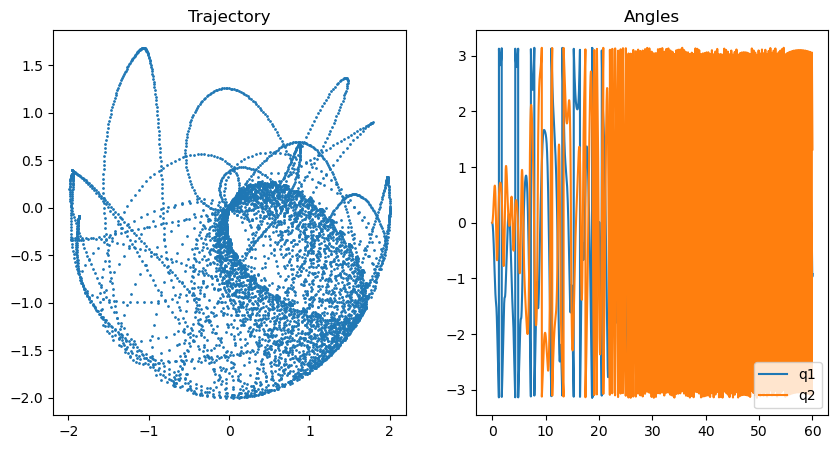

In [63]:
ti = 0
tf = 60
step = 0.01
num_points = int((tf - ti) / step)+1
time = np.linspace(ti, tf, num_points, endpoint=True)
i = 0
x_k = np.array([0, 0, 0, 0], dtype=float) # q1 dq1 q2 dq2
res = np.zeros((len(time), 4), dtype=float)
m1 = 1
m2 = 1
L1_ = 1
L2_ = 1
g_ = 9.81
vel_sat = np.pi/180
dx1, dx2, dx3, dx4 = 0, 0, 0, 0
tau = [0, 0]
while ti <= tf:
    # compensate gravity
    #tau = (G(x_k[0], x_k[1], x_k[2], x_k[3], m1, m2, g_, L1_, L2_) + np.array([[0], [0]])).T[0]
    
    # evaluate the dynamics
    #dx1 = (x_k[2]) # q1d
    #dx2 = (x_k[3]) # q2d
    #dx3 = (x3_d_f(t, x_k[0], x_k[1], x_k[2], x_k[3], tau[0], tau[1], m1, m2, g_, L1_, L2_))
    #dx4 = (x4_d_f(t, x_k[0], x_k[1], x_k[2], x_k[3], tau[0], tau[1], m1, m2, g_, L1_, L2_))
    dx1, dx2, dx3, dx4 = dxdt(x_k, ti, tau[0], tau[1], m1, m2, g_, L1_, L2_)
    # update the states, saturate the angles
    x_k[0] = wrap_to_interval(x_k[0] + step * dx1, -np.pi, np.pi)
    #x_k[0] = np.clip(x_k[0], 0, 2*np.pi)
    #x_k[1] = np.clip(x_k[1], 0, 2*np.pi)
    x_k[1] = wrap_to_interval(x_k[1] + step * dx2, -np.pi, np.pi)
    #x_k[2] = np.clip(x_k[2], -1*vel_sat, vel_sat)
    #x_k[3] = np.clip(x_k[3], -1*vel_sat, vel_sat)
    
    #x_k[0] += step * dx1
    #x_k[1] += step * dx2
    x_k[2] += step * dx3
    x_k[3] += step * dx4
    #x_k[2] = x_k[2] + step * dx3
    #x_k[3] = x_k[3] + step * dx4

    res[i,:] = [x_k[0], x_k[1], x_k[2], x_k[3]]
    i = i + 1

    # update the time
    ti = ti + step
    
p = fk(res[:, 0], res[:, 1], L1_, L2_)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(p[0, :], p[1, :], s=1)
ax[0].set_title("Trajectory")
ax[1].plot(time, res[:, 0], label="q1")
ax[1].plot(time, res[:, 1], label="q2")
ax[1].set_title("Angles")
ax[1].legend()

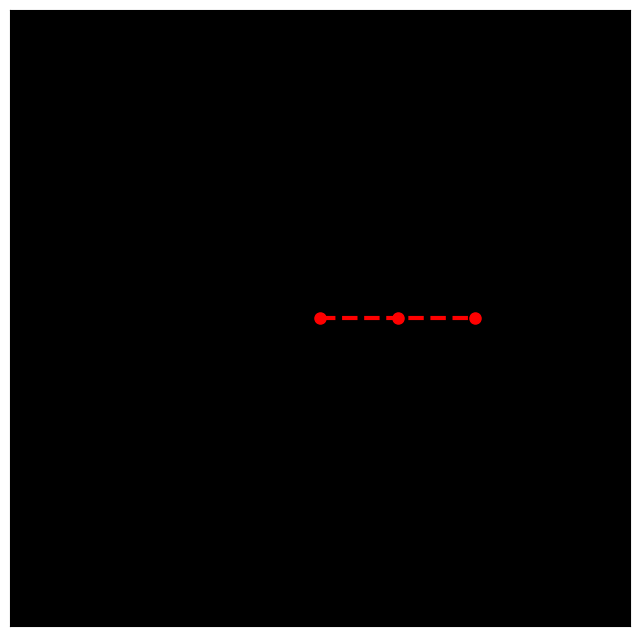

In [64]:
from matplotlib import animation
l1x, l1y, l2x, l2y = get_links(t, res[:, 0], res[:, 1], L1_, L2_)
def animate(i):
    ln1.set_data([0, l1x[i], l2x[i]], [0, l1y[i], l2y[i]])
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=len(time[time<1]))